In [1]:
print('kernel is live')

kernel is live


In [2]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)
# warnings.simplefilter(action='ignore', category='PkgResourcesDeprecationWarning')

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler

import pickle
from multiprocessing import Pool

pd.options.display.max_colwidth = 1000
pd.options.display.float_format = lambda x: '{x:.2g}'.format(x=x)
pd.options.mode.chained_assignment = None

In [4]:
import numpyro
import numpyro.distributions as dist
from numpyro.distributions.constraints import interval
from numpyro.infer import MCMC, NUTS, HMCECS, Predictive
import jax                                                                                                           
import jax.numpy as jnp
from jax import random
import arviz as az
import xarray as xr

numpyro.set_host_device_count(4)
jax.local_device_count()
# numpyro.set_platform('gpu')



4

In [5]:
from data_cleaning_tools import (smooth_data, make_df_monotonic, get_per_capita, 
                                 get_neighbor_mean, get_dxdts, get_tlags, 
                                 make_county_antivax_clusters, get_cluster_profiles, 
                                 weighted_mean,)

# load and prepare data

In [6]:
#data loading tools
confounders = ['RepublicanPct2020', 'RUCC_2013', 'Under18Pct2010', 'Age65AndOlderPct2010', 'Ed5CollegePlusPct','GiniCoeff',
               'PopDensity2010_log', 'BlackNonHispanicPct2010_log', 'HispanicPct2010_log', 
               'AsianNonHispanicPct2010_log', 'MedHHInc_log', 'WhiteNonHispanicPct2010_neglog', 
               'n_tweets_all_time_per_capita_log'] # this list of features can be tested as possible confounding variables

def get_data(smooth_window=None, smooth_order = 1, 
             force_monotonic=True):
    
    #load data
    df = pd.read_parquet('time_series_df.parquet').sort_values(by=['date','FIPS'])
    raw_cols = ['cumulative_vaccinations', 'cumulative_cases', 'cumulative_deaths', 
                'cumulative_antivax_tweets']
    for col in raw_cols: df = df[~df[col].isna()] #filter out any nan data.  this means texas, which has no vax data
    
    #make monotonic and smooth data
    for col in raw_cols: df[col] = df[col].astype(float)
    if smooth_window is not None: df = smooth_data(df, cols = raw_cols, drop_ends=True,
                                                   window_size=smooth_window, order=smooth_order)
    if force_monotonic: df = make_df_monotonic(df, cols=raw_cols, epsilon=1e-5)
         
    #add time step variable
    t = pd.Series(df['date'].unique()).sort_values().reset_index(drop=True).reset_index().rename(columns={'index':'t',0:'date'})
    df = df.merge(right= t , on ='date', how = 'left')

    #compute key variables
    df['N'] = df['population']
    df['V'] = df['cumulative_vaccinations'] 
    df['D'] = df['cumulative_deaths'] 
    df['C'] = df['cumulative_cases']
    df = get_tlags(df, cols = ['C'], lags = list(range(2, 21)))
    df['R'] = df['C_tlag8'] #on average deaths occur 8 days after positive test; contagion typically wanes around the same time for those who dont die
    df['I'] = df['C'] - df['R'] 
    df['S'] = df['N'] - (df['C']+df['V'])
    df['T_a'] = df['cumulative_antivax_tweets']
    df['RT_a'] = df['cumulative_antivax_retweets']
    df['E_a'] = get_neighbor_mean(df, ['T_a'], # E_a = estimated exposure to antivax tweets
                                  neighbor_type = 'retweet', # could also be 'geo', but here is retweet
                                  normalize_edgelist=True
                                  )['T_a_retweet_neighbor_mean'] / df['N']

    # drop dates and counties with undefined t-1 exposures. these are due to no twitter data available.
    df = df.dropna(subset='E_a')
        
    #get lags and dxdts
    dynamic_vars = ['V','D','C','R','I','S','E_a','T_a','RT_a']
    df = get_dxdts(df=df, cols = dynamic_vars, lags = [1])
    df = get_dxdts(df=df, cols = ['E_a','T_a','RT_a'], lags = [8])
    dynamic_vars += [x+'_dxdt1' for x in dynamic_vars]+['E_a_dxdt8','T_a_dxdt8','RT_a_dxdt8']
    df = get_tlags(df=df, cols = dynamic_vars, lags = [1])
    dynamic_vars += [x+'_tlag1' for x in dynamic_vars]
    dynamic_vars += ['C_tlag'+str(i) for i in range(2, 21)]#+['V_tlag8']
    
    #filter by date
        #drop early period where vaccines were not widely available and
        #drop autocorrelated dates, i.e. those with overlapping timelagged variables
    date_filter = pd.DataFrame((df[['date','V']].groupby('date').agg('median')>0.00)
                              ).reset_index().rename(columns={'V':'keep','index':'date'})
    dates_to_keep = (pd.Series(date_filter[date_filter['keep']]['date'].unique()).sort_values(ascending=True)[::-8])[-24:]
    dates_to_keep = dates_to_keep[dates_to_keep<'09-01-2021']
    df = df[df['date'].isin(dates_to_keep)]
        
    #drop unneeded variables
    df = df[['FIPS','state','N','t','date']+dynamic_vars+confounders]
    
    #check that all counties have all dates
    assert len(df) == df['FIPS'].nunique()*df['date'].nunique()
    
    return df


def prep_data_for_MCMC(data, n_fips = None, n_fips_clusters = None, n_PCA_dims=5,
                   cols_used_in_model = ['date','t','FIPS','FIPS_cluster','N', #metadata
                      'confounders','V_tlag1','E_a_dxdt8_tlag1','C_tlag','D_tlag1',#predictors
                      'S_dxdt1','C_dxdt1','R_dxdt1','V_dxdt1','D_dxdt1'] #predicted
                  ):

    #clean copy
    df = data.copy()
    
    #drop very low population counties. they may have unreliable data.
    df = df[df['N']>1000]
    
    #create county clusters for antivax priors
    if n_fips_clusters is not None:
        df = make_county_antivax_clusters(df, cluster_vars = confounders[:-1], #all confounders except tweets_all_time 
                                              n_clusters = n_fips_clusters,
                                              n_PCA_dims = n_PCA_dims)
    else: 
        df['FIPS_cluster']=df['FIPS'].copy()
    
    #combine C_lags
    df['C_tlag'] = list(df[['C']+['C_tlag'+str(i) for i in range(1,21)]].values)
    df['confounders'] = list(MinMaxScaler().fit_transform(df[confounders].values))

    #keep only necessary columns to save memory
    df = df[cols_used_in_model]
    
    #sample the set of counties to save memory
    if n_fips is not None:
        fips_to_keep = pd.Series(df['FIPS'].unique()).sort_values().sample(n_fips, replace=False).reset_index(drop=True)
        df = df[df['FIPS'].isin(fips_to_keep)]

    #rename clusters. descending order by size
    cluster_counts = df[df['t']==df['t'].min()]['FIPS_cluster'].value_counts(
                                                              ).reset_index(
                                                              ).rename(columns={'index':'old_name'})
    cluster_renamer = dict(zip(cluster_counts['old_name'], cluster_counts.index))
    df['FIPS_cluster'] = df['FIPS_cluster'].map(cluster_renamer)

    #ensure sorted
    df = df.sort_values(by=['t','FIPS_cluster','FIPS'], ascending=True).reset_index(drop=True)
    
    #confirm all counties have all dates
    assert len(df)==(df['FIPS'].nunique()*df['t'].nunique())

    return df


def plot_county(data, fips, cols_to_plot = ['S','I','R','V','E_a_dxdt8']#,'D']
                , dxdt=False, ax=None):
    df = data.copy()
    if dxdt: cols_to_plot = [col+'_dxdt1' for col in cols_to_plot]
    df = df[df['FIPS']==fips][['date']+cols_to_plot].set_index('date')
    df = df/df.abs().max()
    df = df.plot(ax=ax)
    plt.title('time series for FIPS '+str(fips))
    plt.ylabel('x / max(x)')
    return


In [7]:
data = get_data(smooth_window=None, smooth_order = 1, force_monotonic=True)

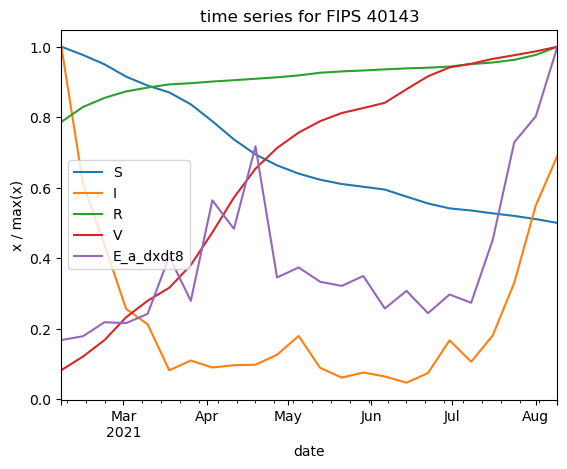

In [8]:
plot_county(data, data.FIPS.sample(1).iloc[0])
plt.show()

In [9]:
df = prep_data_for_MCMC(data, n_fips=400, n_fips_clusters=None, n_PCA_dims=5)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9600 entries, 0 to 9599
Data columns (total 15 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   date             9600 non-null   datetime64[ns]
 1   t                9600 non-null   int64         
 2   FIPS             9600 non-null   int64         
 3   FIPS_cluster     9600 non-null   int64         
 4   N                9600 non-null   int64         
 5   confounders      9600 non-null   object        
 6   V_tlag1          9600 non-null   float64       
 7   E_a_dxdt8_tlag1  9600 non-null   float64       
 8   C_tlag           9600 non-null   object        
 9   D_tlag1          9600 non-null   float64       
 10  S_dxdt1          9600 non-null   float64       
 11  C_dxdt1          9600 non-null   float64       
 12  R_dxdt1          9600 non-null   float64       
 13  V_dxdt1          9600 non-null   float64       
 14  D_dxdt1          9600 non-null   float64

In [10]:
# def shuffle_over_geo(df):
#     # Create a copy of the dataframe to avoid modifying the original
#     df_copy = df.copy()

#     # Get unique FIPS
#     unique_fips = df_copy['FIPS'].unique()

#     # Create a dictionary for each FIPS to hold its E_a_dxdt8_tlag1 values
#     fips_dict = {fips: df_copy.loc[df_copy['FIPS'] == fips, 'E_a_dxdt8_tlag1'].values for fips in unique_fips}

#     # Create a new dataframe to store results
#     df_shuffled = df.copy()

#     # Assign shuffled E_a_dxdt8_tlag1 values
#     FIPS_shuffling_map = dict(zip(sorted(unique_fips), pd.Series(unique_fips).sample(frac=1, replace=False)))
#     for original_fips, shuffled_fips in FIPS_shuffling_map.items():
#         df_shuffled.loc[df_shuffled['FIPS'] == original_fips, 'E_a_dxdt8_tlag1'] = fips_dict[shuffled_fips]

#     return df_shuffled, FIPS_shuffling_map

# def shuffle_over_time(df):
#     # Create a copy of the dataframe to avoid modifying the original
#     df_copy = df.copy()

#     # Get unique FIPS
#     unique_t = df_copy['t'].unique()

#     # Create a dictionary for each FIPS to hold its E_a_dxdt8_tlag1 values
#     t_dict = {t: df_copy.loc[df_copy['t'] == t, 'E_a_dxdt8_tlag1'].values for t in unique_t}

#     # Create a new dataframe to store results
#     df_shuffled = df.copy()

#     # Assign shuffled E_a_dxdt8_tlag1 values
#     t_shuffling_map = dict(zip(sorted(unique_t), pd.Series(unique_t).sample(frac=1, replace=False)))
#     for original_t, shuffled_t in t_shuffling_map.items():
#         df_shuffled.loc[df_shuffled['t'] == original_t, 'E_a_dxdt8_tlag1'] = t_dict[shuffled_t]

#     return df_shuffled, t_shuffling_map

# df_shuffled, _ = shuffle_over_geo(df)
# df = df_shuffled

In [11]:
#print data characteristics

n_t = df['t'].nunique()
n_fips = df['FIPS'].nunique()
cluster_counts = df[df['t']==df['t'].min()]['FIPS_cluster'].value_counts()
cluster_frac = cluster_counts/cluster_counts.sum()

print(n_t)
print(n_fips,'\n')

df_w_confounders = df.merge(data[['FIPS','t']+confounders], on=['FIPS','t'], how='left')
cluster_profiles = get_cluster_profiles(df_w_confounders, confounders)
cluster_profiles['frac_fips_in_cluster'] = cluster_frac
cluster_profiles = cluster_profiles[['frac_fips_in_cluster']+confounders]
# cluster_profiles

24
400 



# define models (SIRVA and SIRV)

Note that the D compartment was eventually dropped, so the code below implements SIRVA not SIRVA.  We have commented out the relevant line which includes D in the model. 

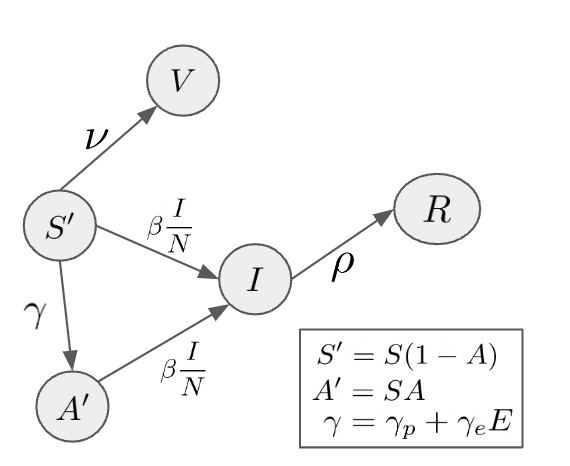

In [12]:
def compute_A_static(dfs, A_0):
    A = jnp.hstack([A_0 for i in range(len(dfs))])
    return A

def compute_A(dfs, A_0, gamma_p, gamma_e, lagged_exposure_col = 'E_a_dxdt8_tlag1'):
    
    #Model Equations:
    # A_dxdt = gamma * (1-A)
    # A = A_0 + sum_{tau<t}(A_dxdt(tau))
    # gamma = gamma_p + gamma_e * E_a_dxdt
        
    #initialize A
    A_t_minus_1 = A_0
    A = [A_t_minus_1]
    dt = 8

    #loop over timesteps to bootstrap A from (A_dxdt and A_0)
    for i in range(1, len(dfs)):
        #unpack data into np array
        E_a_dxdt8 = dfs[i][lagged_exposure_col].values
        
        #compute A_t
        gamma = (gamma_p + gamma_e*E_a_dxdt8)#+ gamma_a*A_t_minus_1)
        dAdt = gamma*(1 - A_t_minus_1)
        A_t = A_t_minus_1 + dt*dAdt
        
        #add A_t to A list and save A_t as A_t-1
        A.append(A_t)
        A_t_minus_1 = A_t
                
    A[0] = A[0].reshape(A[1].shape)
    A = jnp.hstack(A)
    
    return A

In [13]:
def plus(*tuples):
    return tuple([sum(t[i] for t in tuples) for i in range(len(tuples[0]))])

def mul(tuple1, factor):
    return tuple([tuple1[i] * factor for i in range(len(tuple1))])

def runge_kutta4(f, x, h=1, **params):
    k1 = f(*x, **params)
    k2 = f( *plus(x, mul(k1, h/2)), **params)
    k3 = f( *plus(x, mul(k2, h/2)), **params)
    k4 = f( *plus(x, mul(k3, h)), **params)
    dxdt = tuple([(h/6)*(k1[i]+2*k2[i]+2*k3[i]+k4[i]) for i in range(len(k1))])
    return dxdt, h

def dormand_prince(f, x, h=1, tol=1e-2, **params):
    k1 = f(*x, **params)
    k2 = f(*plus(x, mul(k1, h*(1/5))), **params)
    k3 = f(*plus(x, mul(k1, h*(3/40)), mul(k2, h*(9/40))), **params)
    k4 = f(*plus(x, mul(k1, h*(44/45)), mul(k2, h*(-56/15)), mul(k3, h*(32/9))), **params)
    k5 = f(*plus(x, mul(k1, h*(19372/6561)), mul(k2, h*(-25360/2187)), mul(k3, h*(64448/6561)), mul(k4, h*(-212/729))), **params)
    k6 = f(*plus(x, mul(k1, h*(9017/3168)), mul(k2, h*(-355/33)), mul(k3, h*(46732/5247)), mul(k4, h*(49/176)), mul(k5, h*(-5103/18656))), **params)
    k7 = f(*plus(x, mul(k1, h*(35/384)), mul(k3, h*(500/1113)), mul(k4, h*(125/192)), mul(k5, h*(-2187/6784)), mul(k6, h*(11/84))), **params)

    dxdt = tuple([(h)*((35/384)*k1[i] + (500/1113)*k3[i] + (125/192)*k4[i] + (-2187/6784)*k5[i] + (11/84)*k6[i]) for i in range(len(k1))])
    # error = jnp.linalg.norm(jnp.array([(h)*((-1/57600)*k1[i] + (-7/16695)*k3[i] + (3/640)*k4[i] + (187/2100)*k5[i] + (-1/40)*k6[i]) for i in range(len(k1))]))
    # new_h = (h * (tol / error) ** (1/5)) if (error < tol) else h * (tol / error) ** (1/4)
    new_h = h

    return dxdt, new_h

# def integrate(f, x0, t0=0, tf=1, n_steps=1, method=dormand_prince, **params):
#     h = (tf-t0)/n_steps
#     xs = [x0]
#     ts = [t0]
#     for _ in range(n_steps):
#         dxdt, new_h = method(f, (xs[-1]), h, **params)
#         xs.append(plus(xs[-1], dxdt))
#         ts.append(ts[-1] + new_h)
#         h = new_h
#     deltax = tuple([xs[-1][i] - xs[0][i] for i in range(len(xs[0]))])
#     return deltax, (ts, xs)


def integrate(f, x, **params): # more efficient shortcut for n_steps=1
    return dormand_prince(f,x, **params)


In [14]:
#unpack data
n_t = df['t'].nunique()
n_fips = df['FIPS'].nunique()
n_fips_clusters = df['FIPS_cluster'].nunique()
cluster_counts = df[df['t']==df['t'].min()]['FIPS_cluster'].value_counts()
n_confounders = len(confounders)
N = df['N'].values
V_tlag1 = df['V_tlag1'].values
D_tlag1 = df['D_tlag1'].values 
C_tlag = np.stack(df['C_tlag'].values).T
R_tlag1 = C_tlag[9]
I_tlag1 = C_tlag[1] - R_tlag1
S_tlag1 = N - (V_tlag1 + C_tlag[1])
S_tlag1[(S_tlag1<=0)] = 1e-5 #clip illegal values. one county gets slightly-negative S due to an outdated population count and high vax rate
confounds = np.hstack([0.5*np.ones((n_fips,1)), (np.stack(df['confounders'].values))[:n_fips,:]])
dfs_by_t = [x[1] for x in list(df.groupby('t'))] #split df by timestep. make into list of dfs

#define model
def SIRVA_model(df, A_model = 'dynamic'):
    
    #Data Variables:
    # C: cumulative cases to date in the county
    # V: cumulative vaccinations to date in the county
    # D: cumulative deaths to date in the county.   # Deaths were dropped.  This is now the SIRVA model, not the SIRVAD model. 
    # N: population in the county
    # E_a_dxdt: Exposure to antivax tweets in the last 8 days 
    #           Units of exposure are tweets per capita per day in retweet-connected counties

    #Derived and Latent Variables:
    # A: fraction of susceptibles who are antivax (Latent). note that the A here is equivilent to the alpha in the paper.  This notational change in the paper was made for clarity, but was not backpropogated into the code.
    # R := C_{t-8}   #approximate
    # S := N - (C+V)
    # I := C - R
    
    #Infered Parameters:
    # beta: infection rate among susceptible population
    # rho: recovery rate
    # phi: case fatality rate
    # nu: vaccination rate among non-antivax population
    # A_0: inital antivax proportion in county (or cluster of counties)
    # gamma_e: rate of conversions to antivax state due to exposure to tweets, per unit of exposure
    # gamma_p: rate of conversions to antivax state due to other causes
    
    #Model Equations:
    # S_dxdt = -beta*(I/N)*S - nu*S*(1-A)
    # C_dxdt = beta*(I/N)*S
    # R_dxdt = rho*I
    # D_dxdt = phi*R_dxdt   # Deaths were dropped.  This is now the SIRVA model, not the SIRVAD model. 
    # V_dxdt = nu*(S*(1-A))
    # A_dxdt = gamma * (1-A)
    # A = A_0 + sum_{t'<t}(A_dxdt(t'))
    # gamma = gamma_p + gamma_e * E_a_dxdt
    
    #Param & Data Counts:
    # number of free parameters: 4 + 5 + n_fips_clusters + n_t/tau_beta + n_t/tau_nu
    # number of datapoints: 5 * n_t * n_fips
    
    #define timescale for dynamic parameter change. units in 8*tau days
    tau_beta = 3;   assert n_t % tau_beta == 0
    tau_nu = 6;   assert n_t % tau_nu == 0
    
    #define parameter priors
    rho = numpyro.sample('rho', dist.TruncatedNormal(loc=0.1, scale=0.3, low=1e-15, high=1))
    phi = numpyro.sample('phi', dist.TruncatedNormal(loc=0.017, scale=0.1, low=1e-15, high=1))
    beta = numpyro.sample('beta', dist.TruncatedNormal(loc=0.2, scale=0.3, low=1e-15, high=10), sample_shape = (int(n_t/tau_beta),))
    nu = numpyro.sample('nu', dist.TruncatedNormal(loc=0.0025, scale=0.002, low=1e-15, high=1), sample_shape = (int(n_t/tau_nu),))
    if A_model == 'dynamic':
        gamma_p = numpyro.sample('gamma_p', dist.TruncatedNormal(loc=0, scale=0.5/8, low=-1, high=1))
        gamma_e = numpyro.sample('gamma_e', dist.TruncatedNormal(loc=0, scale=1/8, low=-10/8, high=10/8))
    
    #expand time dependent params
    beta = jnp.hstack([beta[i]*np.ones(n_fips*tau_beta) for i in range(int(n_t/tau_beta))])
    nu = jnp.hstack([nu[i]*np.ones(n_fips*tau_nu) for i in range(int(n_t/tau_nu))])
    
    #compute latent variable A
      #note that the A here is equivilent to the alpha_t in the paper. This notational change in the paper was made for clarity, but was not backpropogated into the code.
    if A_model == 'zero':
        A_0 = jnp.zeros(n_fips)
        A = numpyro.deterministic('A', compute_A_static(dfs_by_t, A_0))
    else:
        alpha_0 = numpyro.sample('alpha_0', dist.TruncatedNormal(loc=0.2, scale=0.5, low=0, high=1), 
                           sample_shape = (len(cluster_counts),))
        A_0 = numpyro.deterministic('A_0', jnp.hstack([alpha_0[i]*np.ones(cluster_counts[i]) 
                                                   for i in cluster_counts.index]))
        if A_model == 'dynamic':
            A = numpyro.deterministic('A', compute_A(dfs_by_t, A_0, gamma_p, gamma_e))
        elif A_model == 'static':
            A = numpyro.deterministic('A', compute_A_static(dfs_by_t, A_0))
    
    #define model equations
    S_dxdt = lambda beta, nu, S, I, N, A:   -(nu*(S*(1-A)) + beta*((I/N)*S))
    I_dxdt = lambda beta, rho, I, S, N:     beta*((I/N)*S) - rho*I
    R_dxdt = lambda rho, I:                 rho*I
    D_dxdt = lambda phi, rho, I:            phi*rho*I   #although this isnt commented out, it does not constrain the model fit because D_dxdt_est below is commented out. it is left here so that the SIRVAD model could be reused if necessary. likewise with the inclusion of the phi parameter. 
    V_dxdt = lambda nu, S, A:               nu*(S*(1-A))
    
    #run runge kutta to get dxdt estimates  
    x_dxdt = (lambda S, I, R, D, V, A, N, beta, nu, rho, phi:
                  ( S_dxdt(beta, nu, S, I, N, A), I_dxdt(beta, rho, I, S, N), 
                    R_dxdt(rho, I), D_dxdt(phi, rho, I), V_dxdt(nu, S, A)))
    x_tlag = (S_tlag1, I_tlag1, R_tlag1, D_tlag1, V_tlag1)
    x_dxdt_est, _ = integrate(x_dxdt, x_tlag, A=A, N=N, beta=beta, nu=nu, rho=rho, phi=phi)
    
    #repackage dxdt estimates into numpyro vars. 
    #also reparmeterize I as C, so we can use negbin dist instead of diff of negbins
    (S_dxdt_est, I_dxdt_est, R_dxdt_est, D_dxdt_est, V_dxdt_est) = x_dxdt_est
    S_dxdt_est = numpyro.deterministic('S_dxdt_est', S_dxdt_est)   
    C_dxdt_est = numpyro.deterministic('C_dxdt_est', I_dxdt_est + R_dxdt_est)
    R_dxdt_est = numpyro.deterministic('R_dxdt_est', R_dxdt_est)
#     D_dxdt_est = numpyro.deterministic('D_dxdt_est', D_dxdt_est)
    V_dxdt_est = numpyro.deterministic('V_dxdt_est', V_dxdt_est)
    
    #define concentration terms
    S_dxdt_concentration = numpyro.sample('S_dxdt_concentration', dist.Gamma(6, 1))
    C_dxdt_concentration = numpyro.sample('C_dxdt_concentration', dist.Gamma(6, 1))
    R_dxdt_concentration = numpyro.sample('R_dxdt_concentration', dist.Gamma(6, 1))
#     D_dxdt_concentration = numpyro.sample('D_dxdt_concentration', dist.Gamma(6, 1))
    V_dxdt_concentration = numpyro.sample('V_dxdt_concentration', dist.Gamma(6, 1))

    #define distributions
    NegBin = lambda mean, disp: dist.NegativeBinomial2(mean, disp) 
    S_dxdt_hat = numpyro.sample('S_dxdt_hat', NegBin(-S_dxdt_est, S_dxdt_concentration), obs = -df['S_dxdt1'].values)
    C_dxdt_hat = numpyro.sample('C_dxdt_hat', NegBin(C_dxdt_est, C_dxdt_concentration), obs = df['C_dxdt1'].values)
    R_dxdt_hat = numpyro.sample('R_dxdt_hat', NegBin(R_dxdt_est, R_dxdt_concentration), obs = df['R_dxdt1'].values)
#     D_dxdt_hat = numpyro.sample('D_dxdt_hat', NegBin(D_dxdt_est, D_dxdt_concentration), obs = df['D_dxdt1'].values)
    V_dxdt_hat = numpyro.sample('V_dxdt_hat', NegBin(V_dxdt_est, V_dxdt_concentration), obs = df['V_dxdt1'].values)
    
    return


In [15]:
#baseline model, sets A=0 for all times and counties.  SIRV
def SIRV_model(df):
    return SIRVA_model(df, A_model = 'zero')

#baseline model, sets gamma_e=0 and gamma_p=0
def SIRVA_static_model(df):
    return SIRVA_model(df, A_model = 'static')


# run our model (SIRVA)

In [16]:
rngkey = random.PRNGKey(0)

In [17]:
# n_burn = 5000
# n_sample = 2000
n_burn = 2500
n_sample = 1500
# n_burn = 1500
# n_sample = 1000
# n_burn = 500
# n_sample = 700
# n_burn = 100
# n_sample = 100

kernel = NUTS(SIRVA_model)
data_dict = {'df':df}
mcmc_SIRVA = MCMC(sampler=kernel, num_warmup=n_burn, num_samples=n_sample, num_chains=3, chain_method='parallel')
mcmc_SIRVA.run(rngkey, **data_dict)

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

In [18]:
with open("mcmc_res.pickle", "wb") as output_file:
    pickle.dump(mcmc_SIRVA, output_file)
df.to_parquet('mcmc_res_data_df.parquet')

In [19]:
mcmc_SIRVA.print_summary()


                            mean       std    median      5.0%     95.0%     n_eff     r_hat
  C_dxdt_concentration      0.64      0.01      0.64      0.62      0.66   7093.62      1.00
  R_dxdt_concentration      0.89      0.02      0.89      0.86      0.91   7501.80      1.00
  S_dxdt_concentration      1.00      0.01      1.00      0.97      1.02   6515.32      1.00
  V_dxdt_concentration      0.79      0.01      0.79      0.77      0.80   7086.56      1.00
            alpha_0[0]      0.62      0.07      0.63      0.51      0.73   5248.82      1.00
            alpha_0[1]      0.84      0.03      0.84      0.79      0.88   6234.90      1.00
            alpha_0[2]      0.75      0.04      0.75      0.68      0.82   5735.44      1.00
            alpha_0[3]      0.55      0.08      0.56      0.42      0.68   4818.04      1.00
            alpha_0[4]      0.83      0.03      0.83      0.78      0.88   6648.33      1.00
            alpha_0[5]      0.71      0.05      0.72      0.63      0

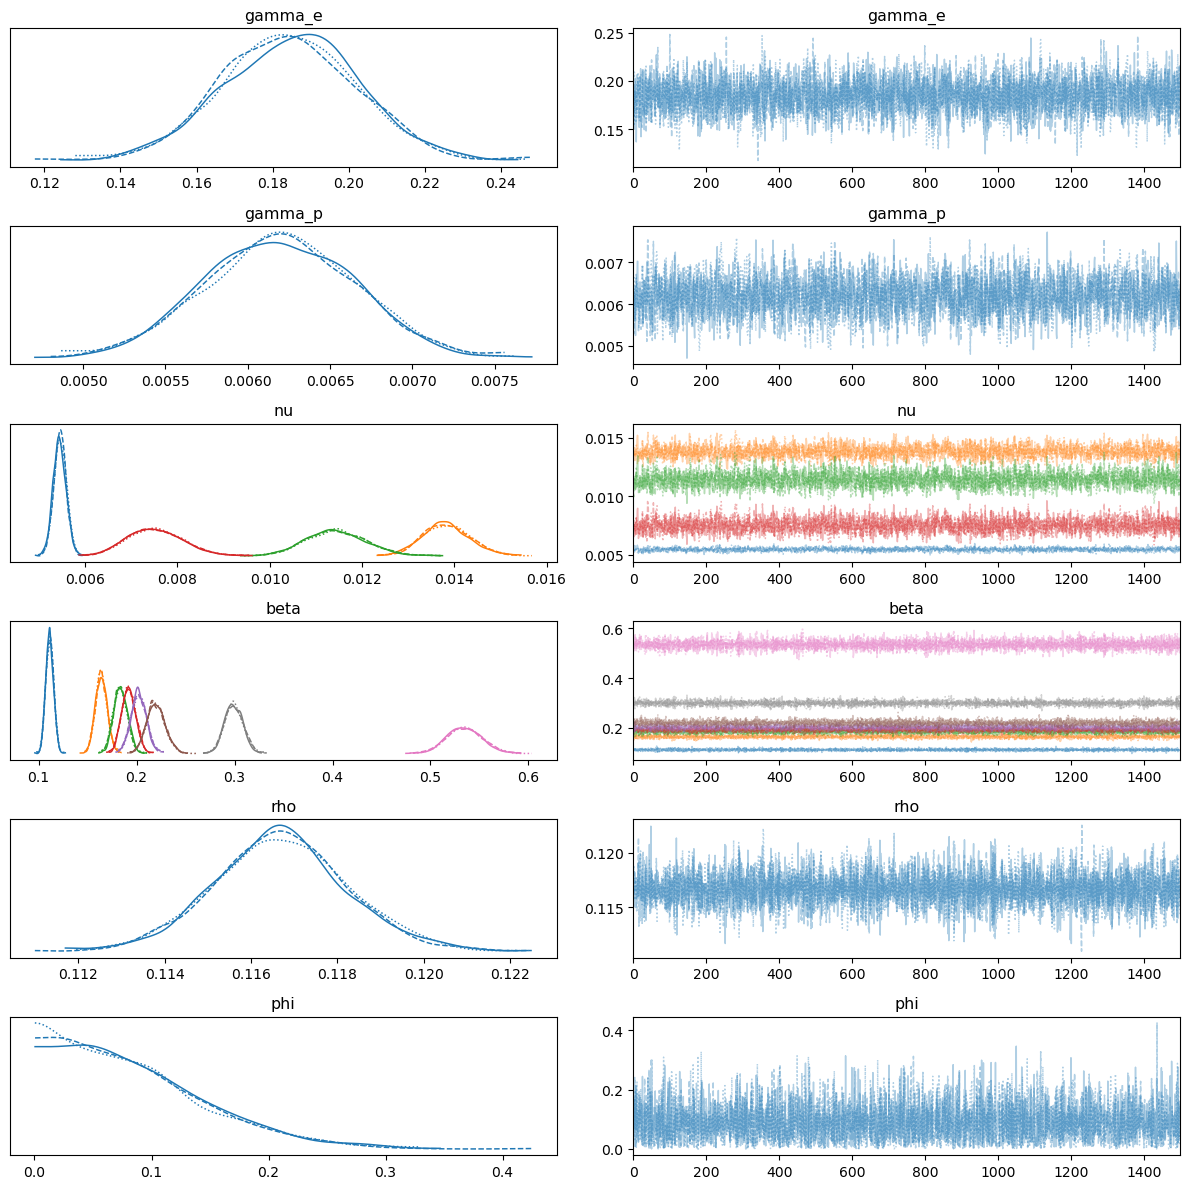

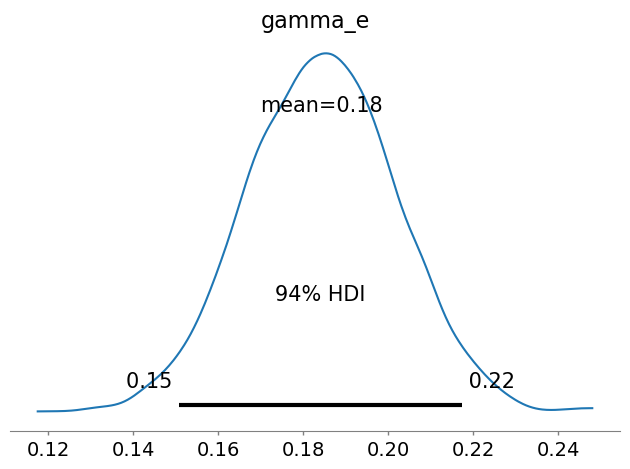

In [20]:
# check traces to confirm convergence

#reformat data
idata = az.from_numpyro(mcmc_SIRVA)

#select variables to plot
var_names=[
           'gamma_e',#'gamma_a',
           'gamma_p','nu',#'alpha',
           'beta','rho','phi',
#            'C_dxdt_concentration','D_dxdt_concentration','R_dxdt_concentration',
#            'S_dxdt_concentration','V_dxdt_concentration',
          ]

#plot trace
az.plot_trace(idata, var_names = var_names)#, coords = coords )
plt.tight_layout()
plt.show()
az.plot_posterior(idata, var_names = ['gamma_e'])
plt.tight_layout()
plt.show()


del idata

# run baseline model (SIRVA_static)

In [21]:
rngkey = random.PRNGKey(0)

kernel = NUTS(SIRVA_static_model)
data_dict = {'df':df}
mcmc_SIRVA_static = MCMC(sampler=kernel, num_warmup=n_burn, num_samples=n_sample, num_chains=4, chain_method='parallel')
mcmc_SIRVA_static.run(rngkey, **data_dict);

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

  0%|          | 0/4000 [00:00<?, ?it/s]

2025-05-10 04:08:31.525396: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:65] 
********************************
[Compiling module pmap__unnamed_wrapped_function_] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************
2025-05-10 04:10:07.738936: E external/org_tensorflow/tensorflow/compiler/xla/service/slow_operation_alarm.cc:133] The operation took 3m36.219099s

********************************
[Compiling module pmap__unnamed_wrapped_function_] Very slow compile?  If you want to file a bug, run with envvar XLA_FLAGS=--xla_dump_to=/tmp/foo and attach the results.
********************************


In [22]:
mcmc_SIRVA_static.print_summary()


                            mean       std    median      5.0%     95.0%     n_eff     r_hat
  C_dxdt_concentration      0.64      0.01      0.64      0.63      0.66   6073.81      1.00
  R_dxdt_concentration      0.89      0.02      0.89      0.86      0.91   5407.30      1.00
  S_dxdt_concentration      0.98      0.01      0.98      0.96      1.00   6629.14      1.00
  V_dxdt_concentration      0.77      0.01      0.78      0.76      0.79   6611.29      1.00
            alpha_0[0]      0.65      0.06      0.66      0.55      0.76   5123.73      1.00
            alpha_0[1]      0.85      0.03      0.85      0.80      0.89   4997.54      1.00
            alpha_0[2]      0.77      0.04      0.77      0.70      0.83   5945.04      1.00
            alpha_0[3]      0.68      0.06      0.69      0.59      0.77   4999.51      1.00
            alpha_0[4]      0.83      0.03      0.83      0.78      0.88   5176.62      1.00
            alpha_0[5]      0.71      0.05      0.72      0.63      0

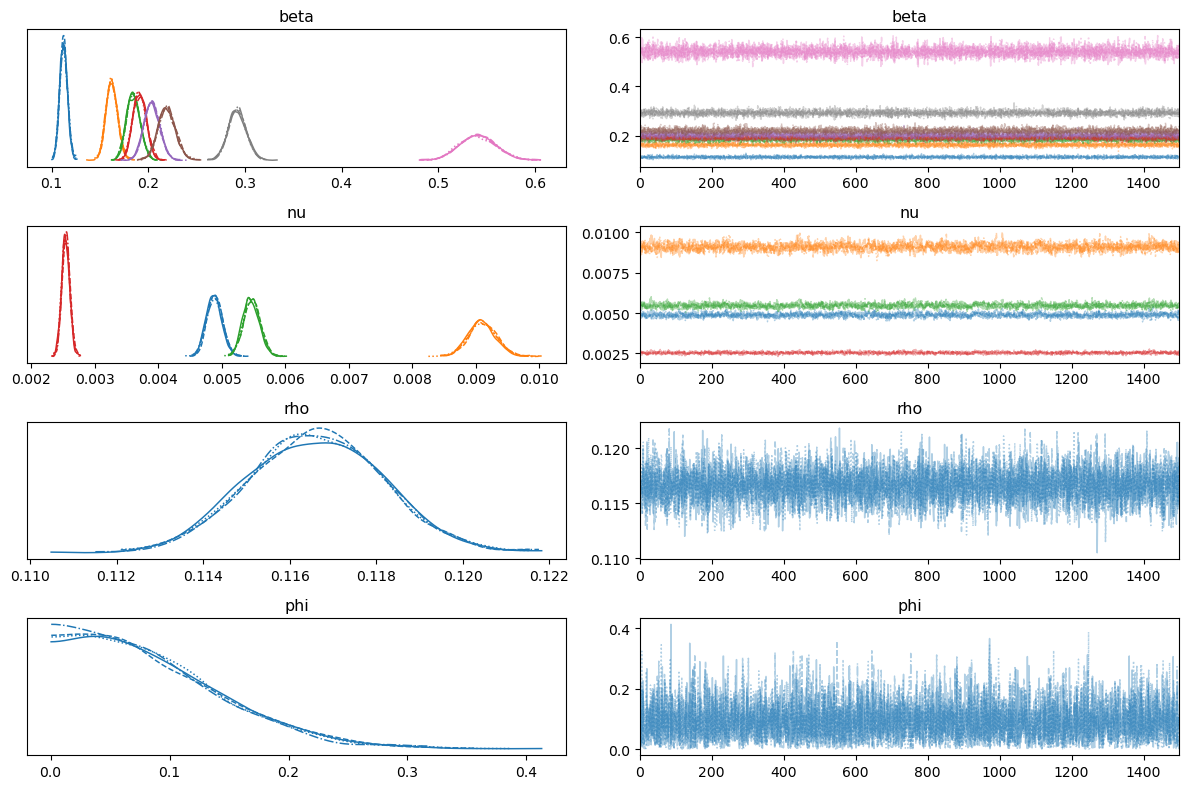

In [23]:
#select variables to plot
var_names=['beta','nu','rho','phi',
#            'C_dxdt_concentration','D_dxdt_concentration','R_dxdt_concentration',
#            'S_dxdt_concentration','V_dxdt_concentration',
          ]

#check trace for convergence
az.plot_trace(az.from_numpyro(mcmc_SIRVA_static), var_names = var_names)
plt.tight_layout()
plt.show()

# run baseline model (SIRV)

In [24]:
rngkey = random.PRNGKey(0)

kernel = NUTS(SIRV_model)
data_dict = {'df':df}
mcmc_SIRV = MCMC(sampler=kernel, num_warmup=1000, num_samples=1000, num_chains=4, chain_method='parallel')
mcmc_SIRV.run(rngkey, **data_dict);

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

  0%|          | 0/2000 [00:00<?, ?it/s]

In [25]:
mcmc_SIRV.print_summary()


                            mean       std    median      5.0%     95.0%     n_eff     r_hat
  C_dxdt_concentration      0.64      0.01      0.64      0.63      0.66   5211.12      1.00
  R_dxdt_concentration      0.89      0.02      0.88      0.86      0.91   4770.90      1.00
  S_dxdt_concentration      0.80      0.01      0.80      0.78      0.82   4926.58      1.00
  V_dxdt_concentration      0.63      0.01      0.63      0.62      0.64   5180.41      1.00
               beta[0]      0.11      0.00      0.11      0.11      0.12   4826.16      1.00
               beta[1]      0.16      0.01      0.16      0.15      0.17   4540.54      1.00
               beta[2]      0.18      0.01      0.18      0.17      0.19   4862.71      1.00
               beta[3]      0.20      0.01      0.20      0.18      0.21   4540.42      1.00
               beta[4]      0.21      0.01      0.21      0.19      0.22   5506.98      1.00
               beta[5]      0.22      0.01      0.22      0.21      0

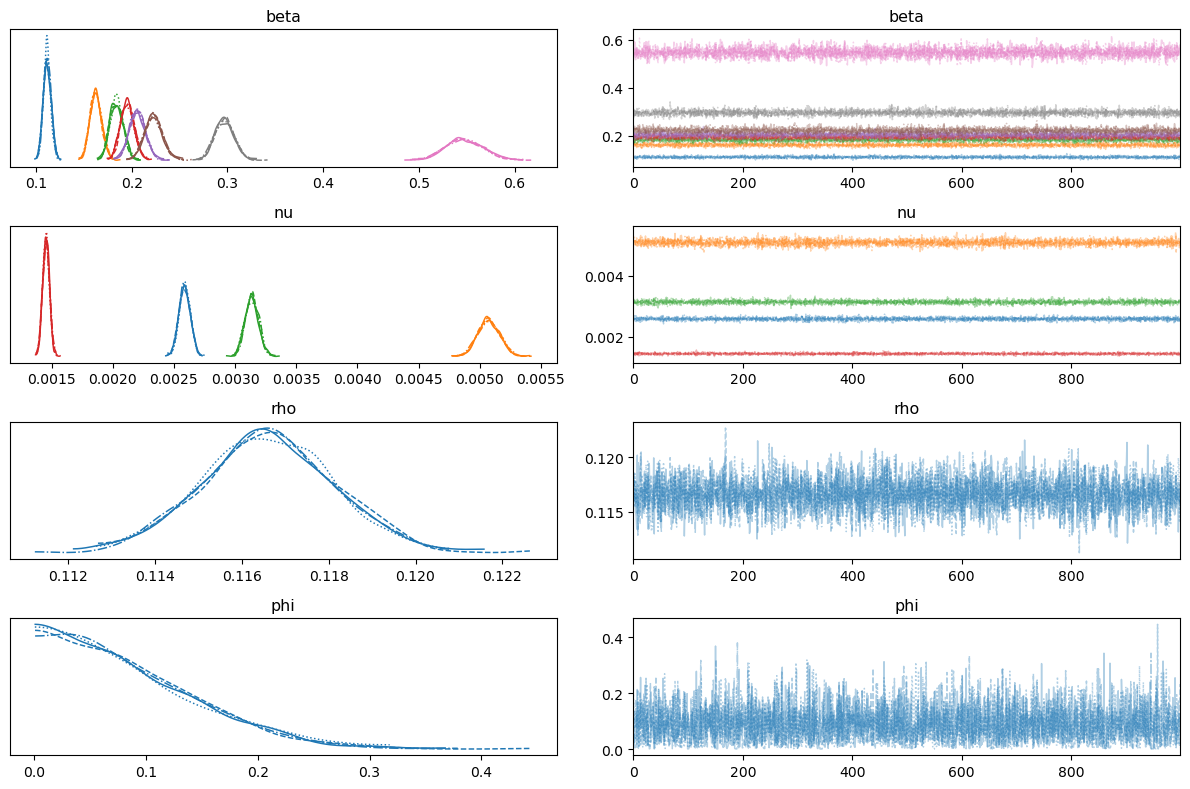

In [26]:
#select variables to plot
var_names=['beta','nu','rho','phi',
#            'C_dxdt_concentration','D_dxdt_concentration','R_dxdt_concentration',
#            'S_dxdt_concentration','V_dxdt_concentration',
          ]

#check trace for convergence
az.plot_trace(az.from_numpyro(mcmc_SIRV), var_names = var_names)
plt.tight_layout()
plt.show()

# information criterion evaluation

In [27]:
def combine_log_likelihoods(idata):
    data_vars = list(idata['log_likelihood'].keys())    
    idata['log_likelihood']['total_log_likelihood'] = xr.DataArray(
        np.stack([idata.log_likelihood[var] for var in data_vars]
                ).sum(axis=0),
        dims = ['chain','draw','observation']
    )
    return idata   

def get_LOO(idata, scale=None):
    LOO = az.loo(combine_log_likelihoods(idata), 
                   var_name = 'total_log_likelihood', 
                   scale=scale)
    return LOO

print('Closer to 0 is better')
print('SIRVA:', get_LOO(az.from_numpyro(mcmc_SIRVA), scale="log"), '\n\n')
print('SIRVA_static:', get_LOO(az.from_numpyro(mcmc_SIRVA_static), scale="log"), '\n\n')
print('SIRV:', get_LOO(az.from_numpyro(mcmc_SIRV), scale="log"), '\n\n')


Closer to 0 is better
SIRVA: Computed from 4500 posterior samples and 9600 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -171627.48   700.14
p_loo      708.10        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     9516   99.1%
 (0.5, 0.7]   (ok)         54    0.6%
   (0.7, 1]   (bad)        15    0.2%
   (1, Inf)   (very bad)   15    0.2%
 


SIRVA_static: Computed from 6000 posterior samples and 9600 observations log-likelihood matrix.

         Estimate       SE
elpd_loo -171782.07   699.23
p_loo      721.66        -

There has been a warning during the calculation. Please check the results.
------

Pareto k diagnostic values:
                         Count   Pct.
(-Inf, 0.5]   (good)     9511   99.1%
 (0.5, 0.7]   (ok)         52    0.5%
   (0.7, 1]   (bad)        25    0.3%
   (1, Inf)   (very bad)   12    0.1%
 


SIRV: Compute

# Simulation tools

In [28]:
def get_posterior_samples(idata, param_names=['A_0','alpha_0','gamma_e','gamma_p','beta','rho','nu']):#,'phi']): 
    posterior_samples = dict()
    for param in param_names:
        posterior_samples[param] = np.array(idata['posterior'][param])
    return posterior_samples

def get_posterior_means(idata=None, posterior_samples=None, param_names=['A_0','alpha_0','gamma_e','gamma_p','beta','rho','nu']):#,'phi']): 
    if idata is None and posterior_samples is None: raise Exception('Must provide idata or posterior_samples')
    if posterior_samples is None: posterior_samples = get_posterior_samples(idata, param_names)
    posterior_means = dict()
    for k in posterior_samples.keys():
#         if 'dxdt' in k: continue
        posterior_means[k] = posterior_samples[k].mean(axis=0).mean(axis=0)
#         posterior_means[k] = float(posterior_samples[k].mean(axis=list(range(len(posterior_samples[k].shape))))) #take mean over chains and samples
    return posterior_means
             

In [29]:
def SIRVA_model_sim(params, df, A_model='dynamic'):
    
    #unpack params
    beta = params['beta']
    nu = params['nu']
    rho = params['rho']
#     phi = params['phi']
    gamma_e = params['gamma_e']
    gamma_p = params['gamma_p']
    gamma_a = None #params['gamma_a']
    A_0 = params['A_0']
    
    #unpack data
    n_t = df['t'].nunique()
    n_fips = df['FIPS'].nunique()
    n_fips_clusters = df['FIPS_cluster'].nunique()
    cluster_counts = df[df['t']==df['t'].min()]['FIPS_cluster'].value_counts()
    n_confounders = len(confounders)
    N = df['N'].values
    V_tlag1 = df['V_tlag1'].values
    D_tlag1 = df['D_tlag1'].values
    C_tlag = np.stack(df['C_tlag'].values).T
    R_tlag1 = C_tlag[9]
    I_tlag1 = C_tlag[1] - R_tlag1
    S_tlag1 = N - (V_tlag1 + C_tlag[1])
    S_tlag1[(S_tlag1<=0)] = 1e-5 #clip illegal values. one county gets slightly-negative S due to an outdated population count and high vax rate
    confounds = np.hstack([0.5*np.ones((n_fips,1)), (np.stack(df['confounders'].values))[:n_fips,:]])
    dfs_by_t = [x[1] for x in list(df.groupby('t'))] #split df by timestep. make into list of dfs

    #expand time dependent params
    tau_beta = 3;   assert n_t % tau_beta == 0
    tau_nu = 6;   assert n_t % tau_nu == 0
    beta = jnp.hstack([beta[i]*np.ones(n_fips*tau_beta) for i in range(int(n_t/tau_beta))])
    nu = jnp.hstack([nu[i]*np.ones(n_fips*tau_nu) for i in range(int(n_t/tau_nu))])
    
    #compute latent variable A
    if A_model == 'dynamic':
        A = numpyro.deterministic('A', compute_A(dfs_by_t, A_0, gamma_p, gamma_e, lagged_exposure_col='E_a_dxdt8_tlag1'))
    elif A_model == 'static':
        A = numpyro.deterministic('A', compute_A_static(dfs_by_t, A_0))
    elif A_model == 'zero':
        A_0 = jnp.zeros(n_fips)
        A = numpyro.deterministic('A', compute_A_static(dfs_by_t, A_0))

    #define model equations
    S_dxdt = lambda beta, nu, S, I, N, A:   -(nu*(S*(1-A)) + beta*((I/N)*S))
    I_dxdt = lambda beta, rho, I, S, N:     beta*((I/N)*S) - rho*I
    R_dxdt = lambda rho, I:                 rho*I
    V_dxdt = lambda nu, S, A:               nu*(S*(1-A))
#     D_dxdt = lambda phi, rho, I:            phi*rho*I
    
    #run runge kutta to get dxdt estimates  
    x_dxdt = (lambda S, I, R, #D,
              V, A, N, beta, nu, rho:#, phi:
                  ( S_dxdt(beta, nu, S, I, N, A), I_dxdt(beta, rho, I, S, N), 
                    R_dxdt(rho, I),# D_dxdt(phi, rho, I),
                    V_dxdt(nu, S, A)))
    x_tlag = (S_tlag1, I_tlag1, R_tlag1, #D_tlag1, 
              V_tlag1)
    x_dxdt_est,_ = integrate(x_dxdt, x_tlag, A=A, N=N, beta=beta, nu=nu, rho=rho)#, phi=phi)
    
    #unpack dxdt vars
    #also reparmeterize I as C, so we can use negbin dist instead of diff of negbins
    (S_dxdt_est, I_dxdt_est, R_dxdt_est, #D_dxdt_est,
     V_dxdt_est) = x_dxdt_est
    C_dxdt_est = I_dxdt_est + R_dxdt_est
    
    #package results
    sim_results = {
        'A':A,
        'V_dxdt_est':V_dxdt_est,
        'R_dxdt_est':R_dxdt_est,
        'C_dxdt_est':C_dxdt_est,
#         'D_dxdt_est':D_dxdt_est,
        'S_dxdt_est':S_dxdt_est,
    }
    return sim_results


def SIRVA_model_sim_conditional_difference(posterior_params, df_true, df_counterfactual):
    results = SIRVA_model_sim(posterior_params, df_true)
    counterfactual_results = SIRVA_model_sim(posterior_params, df_counterfactual)
    difference_results = dict()
    for var in results.keys():
        difference_results[var] = counterfactual_results[var] - results[var]
    return difference_results

def SIRVA_model_sim_conditional_difference_zero_A_counterfactual(posterior_params, df_true):
    results = SIRVA_model_sim(posterior_params, df_true)
    counterfactual_results = SIRVA_model_sim(posterior_params, df_true, A_model='zero')
    difference_results = dict()
    for var in results.keys():
        difference_results[var] = counterfactual_results[var] - results[var]
    return difference_results

def sim_over_samples(sim, samples, df, **kwargs):
    params = list(samples.keys())
    n_chains, n_samples = samples[params[0]].shape[:2]

    samples_unpacked = list()
    for chain in range(n_chains):
        current_chain_samples = list()
        for sample in range(n_samples):
            current_chain_samples.append({k:samples[k][chain, sample] for k in samples.keys()})
        samples_unpacked.append(current_chain_samples)

    results = list()
    for j, chain in enumerate(samples_unpacked):
        current_chain_results = list()
        for i, sample in enumerate(chain):
#             if i%100==0: print(i+j*len(samples_unpacked[0]))
            sample_results = sim(sample, df, **kwargs)
            current_chain_results.append(sample_results)
        results.append(current_chain_results)

    output_variables = list(results[0][0].keys())
    results_repackaged = {k:[] for k in output_variables}
    for var in output_variables:
        for chain in range(n_chains):
            current_chain_vals = list()
            for sample in range(n_samples):
                sample_val = results[chain][sample][var]
                current_chain_vals.append(sample_val)
            results_repackaged[var].append(np.stack(current_chain_vals))
        results_repackaged[var] = np.stack(results_repackaged[var])

    return results_repackaged



In [30]:
posterior_samples = get_posterior_samples(az.from_numpyro(mcmc_SIRVA))

# counterfactual case: zero antivax tweets

(i.e. T_a = 0 and therefore E_a = 0 for all counties and times)

In [31]:
#run counteractual simulation
df_counterfactual = df.copy()
df_counterfactual['E_a_dxdt8_tlag1'] = 0
counterfactual_deltas_samples = sim_over_samples(SIRVA_model_sim_conditional_difference, 
                                      posterior_samples, df, df_counterfactual = df_counterfactual)

In [32]:
counterfactual_deltas = get_posterior_means(posterior_samples = counterfactual_deltas_samples)
counterfactual_deltas = pd.DataFrame(counterfactual_deltas)
counterfactual_deltas[['date','FIPS', 'N']] = df[['t','FIPS','N']
                                                       ].merge(data[['t','date']].drop_duplicates(), 
                                                               on='t',how='left'
                                                              )[['date','FIPS','N']]

for col in counterfactual_deltas.columns:
    if '_est' in col:
        counterfactual_deltas[col+'/N'] = (counterfactual_deltas[col]
                                                 /counterfactual_deltas['N'])
        counterfactual_deltas = counterfactual_deltas.drop(columns=[col])
pop_weighted_mean = lambda x: np.average(x, weights=counterfactual_deltas.loc[x.index, 'N'])
counterfactual_deltas = counterfactual_deltas.groupby('date').agg(pop_weighted_mean).drop(columns=['FIPS','N'])

In [33]:
counterfactual_deltas

,A,V_dxdt_est/N,R_dxdt_est/N,C_dxdt_est/N,S_dxdt_est/N
date,,,,,
2021-02-06,0,0,0,0,0
2021-02-14,-0.00026,1.2e-06,-5.5e-12,-1.5e-10,-1.2e-06
2021-02-22,-0.00054,2.5e-06,-7.6e-12,-2e-10,-2.5e-06
2021-03-02,-0.00074,3.3e-06,-1.5e-11,-4e-10,-3.3e-06
2021-03-10,-0.001,4.6e-06,-1.7e-11,-4.6e-10,-4.6e-06
2021-03-18,-0.0014,6.1e-06,-2.3e-11,-6.1e-10,-6.1e-06
2021-03-26,-0.0017,1.7e-05,-7.8e-11,-2.1e-09,-1.7e-05
2021-04-03,-0.0021,2.2e-05,-1.1e-10,-2.9e-09,-2.2e-05
2021-04-11,-0.0025,2.4e-05,-1.2e-10,-3.3e-09,-2.4e-05


In [34]:
# print('increase in antivaxers per capita under counterfactual:\n', counterfactual_deltas['A'][-1])
print('increase in vaccinations per capita under counterfactual:\n', counterfactual_deltas['V_dxdt_est/N'].mean()*8*n_t)
# print('increase in cases per capita under counterfactual:\n', counterfactual_deltas['C_dxdt_est/N'].mean()*8*n_t)
# print('increase in deaths per capita under counterfactual:\n', counterfactual_deltas['D_dxdt_est/N'].mean()*8*n_t)

print('increase in vaccinations under counterfactual:\n', counterfactual_deltas['V_dxdt_est/N'].mean()*8*n_t*337000000)


increase in vaccinations per capita under counterfactual:
 0.0029232616575297164
increase in vaccinations under counterfactual:
 985139.1785875144


# counterfactual case: zero unvaccinatables

(i.e., A=0 for all counties and times)

Note this is NOT the counterfactual "what if there were no antivaxxers" because A also includes people who are unable to be vaccinated (e.g. because of lack of access or medical restrictions).

Also note that this method of counterfactual analysis is only valid for small purturbations of S,C,R,V variables.  If the SCRV variables change a lot, as in this case, we cannot trust the estimates of the magnitude of their change. All we can say for sure is that they change a lot in the direction we measured.  In this case, we measure a ~50% change in V. We cannot trust this figure. We can only say it changed much more than a few percent. 

In [35]:
#run counteractual simulation
counterfactual_deltas_samples = sim_over_samples(SIRVA_model_sim_conditional_difference_zero_A_counterfactual, 
                                      posterior_samples, df)

In [36]:
counterfactual_deltas = get_posterior_means(posterior_samples = counterfactual_deltas_samples)
counterfactual_deltas = pd.DataFrame(counterfactual_deltas)
counterfactual_deltas[['date','FIPS', 'N']] = df[['t','FIPS','N']
                                                       ].merge(data[['t','date']].drop_duplicates(), 
                                                               on='t',how='left'
                                                              )[['date','FIPS','N']]

for col in counterfactual_deltas.columns:
    if '_est' in col:
        counterfactual_deltas[col+'/N'] = (counterfactual_deltas[col]
                                                 /counterfactual_deltas['N'])
        counterfactual_deltas = counterfactual_deltas.drop(columns=[col])
pop_weighted_mean = lambda x: np.average(x, weights=counterfactual_deltas.loc[x.index, 'N'])
counterfactual_deltas = counterfactual_deltas.groupby('date').agg(pop_weighted_mean).drop(columns=['FIPS','N'])

In [37]:
counterfactual_deltas

,A,V_dxdt_est/N,R_dxdt_est/N,C_dxdt_est/N,S_dxdt_est/N
date,,,,,
2021-02-06,-0.32,0.0016,-9.8e-09,-2.6e-07,-0.0016
2021-02-14,-0.36,0.0017,-7.6e-09,-2e-07,-0.0017
2021-02-22,-0.39,0.0018,-5.7e-09,-1.5e-07,-0.0018
2021-03-02,-0.42,0.0019,-8.6e-09,-2.3e-07,-0.0019
2021-03-10,-0.45,0.002,-7.7e-09,-2.1e-07,-0.002
2021-03-18,-0.48,0.0021,-7.7e-09,-2.1e-07,-0.0021
2021-03-26,-0.5,0.0054,-2.4e-08,-6.3e-07,-0.0054
2021-04-03,-0.53,0.0055,-2.7e-08,-7.2e-07,-0.0055
2021-04-11,-0.55,0.0055,-2.8e-08,-7.5e-07,-0.0055


In [38]:
# print('increase in antivaxers per capita under counterfactual:\n', counterfactual_deltas['A'][-1])
print('increase in vaccinations per capita under counterfactual:\n', counterfactual_deltas['V_dxdt_est/N'].mean()*8*n_t)
# print('increase in cases per capita under counterfactual:\n', counterfactual_deltas['C_dxdt_est/N'].mean()*8*n_t)
# print('increase in deaths per capita under counterfactual:\n', counterfactual_deltas['D_dxdt_est/N'].mean()*8*n_t)

print('increase in vaccinations under counterfactual:\n', counterfactual_deltas['V_dxdt_est/N'].mean()*8*n_t*337000000)



increase in vaccinations per capita under counterfactual:
 0.6785761826027186
increase in vaccinations under counterfactual:
 228680173.53711617
